In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from ema_workbench import (Policy, MultiprocessingEvaluator, save_results, load_results)

from ema_workbench.analysis import parcoords, prim

from problem_formulation import get_model_for_problem_formulation

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
pareto_policies = pd.read_csv('data/Pareto_Optimal_Results.csv')
dike_model, steps = get_model_for_problem_formulation(2)

In [3]:
pareto_policies.columns

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths',
       'Unnamed: 0', 'All Costs'],
      dtype='object')

In [ ]:
policy_list = []
for i, policy in pareto_policies.iterrows():
    policy_dictionary = policy.to_dict()
    name = f"policy_{i}"
    policy_list.append(Policy(name = name, **policy_dictionary))

In [ ]:
n_scenarios = 1000

with MultiprocessingEvaluator(dike_model) as evaluator: 
    results = evaluator.perform_experiments(scenarios = n_scenarios, policies = policy_list)

100%|████████████████████████████████████| 93000/93000 [38:35<00:00, 40.17it/s]


In [ ]:
def signal_to_noise(data, x):
    mean = np.mean(data)
    std = np.std(data)
    return mean * std

In [41]:
experiments, outcomes = results

all_scores = {}
for i in np.unique(experiments['policy']):
    scores = {}
    select_policy = experiments['policy'] == i
    for j in dike_model.outcomes:
        x = outcomes[j.name][select_policy]
        ratio = signal_to_noise(x, j.kind)
        scores[j.name] = ratio
        all_scores[i] = scores
            
scores_df = pd.DataFrame.from_dict(all_scores).T
scores_df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy_0,1.731670e+18,0.0,0.0,0.000000e+00,1.679671
policy_1,1.431992e+18,0.0,0.0,0.000000e+00,1.010867
policy_10,1.627336e+18,0.0,0.0,2.709551e+08,0.185715
policy_11,1.665812e+18,0.0,0.0,2.826160e+08,0.212390
policy_12,1.431334e+18,0.0,0.0,1.827394e+08,0.131045
...,...,...,...,...,...
policy_89,9.219345e+17,0.0,0.0,9.055762e+08,0.030564
policy_9,1.513706e+18,0.0,0.0,0.000000e+00,1.149483
policy_90,1.114348e+18,0.0,0.0,6.115101e+08,0.022175
policy_91,4.762001e+17,0.0,0.0,4.535898e+08,0.004858


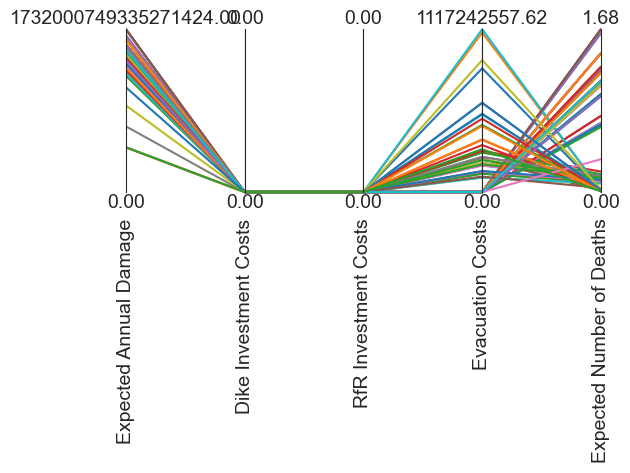

In [32]:
limits = parcoords.get_limits(scores_df)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']] = 0
axes = parcoords.ParallelAxes(limits)
axes.plot(scores_df)
plt.show()

In [44]:

filtered_scores = scores_df.drop(
    scores_df['Expected Number of Deaths'].nlargest(70).index)
print(len(filtered_scores))

filtered_policies = filtered_scores.reset_index()

filtered_policies = filtered_policies.iloc[:, 0]
filtered_policies.tolist()

23


['policy_15',
 'policy_16',
 'policy_17',
 'policy_19',
 'policy_20',
 'policy_36',
 'policy_38',
 'policy_40',
 'policy_54',
 'policy_62',
 'policy_70',
 'policy_71',
 'policy_74',
 'policy_75',
 'policy_78',
 'policy_82',
 'policy_84',
 'policy_86',
 'policy_88',
 'policy_89',
 'policy_90',
 'policy_91',
 'policy_92']

In [48]:
# Create merged results DataFrame
results_df = pd.DataFrame(experiments).copy()
for k, v in outcomes.items():
    results_df[k] = v

# Filter for best policies
best_results = results_df[results_df['policy'].isin(filtered_policies)]

In [ ]:

# Preallocate regret storage
overall_regret = {}
max_regret = {}

# Loop through each outcome
for outcome in dike_model.outcomes:
    name = outcome.name

    # Pivot data to get outcome values by [scenario, policy]
    pivot = best_results.pivot(index='scenario', columns='policy', values=name)

    # Compute regret: max value in each row (scenario) minus each policy's value
    regret_matrix = (pivot.max(axis=1).values[:, np.newaxis] - pivot).abs()

    # Store results
    overall_regret[name] = regret_matrix
    max_regret[name] = regret_matrix.max()

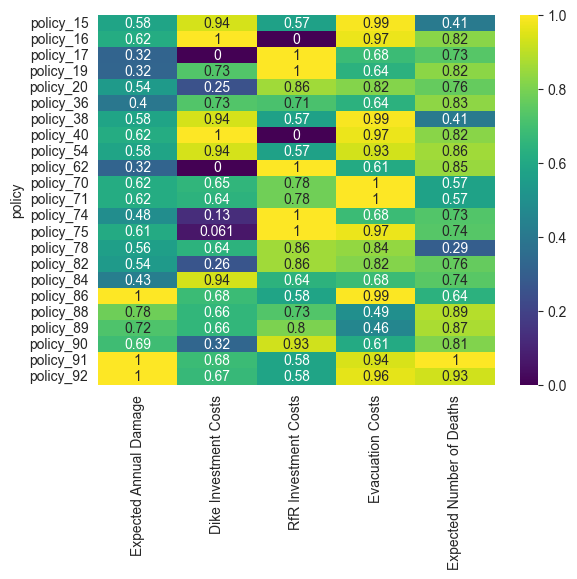

In [50]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

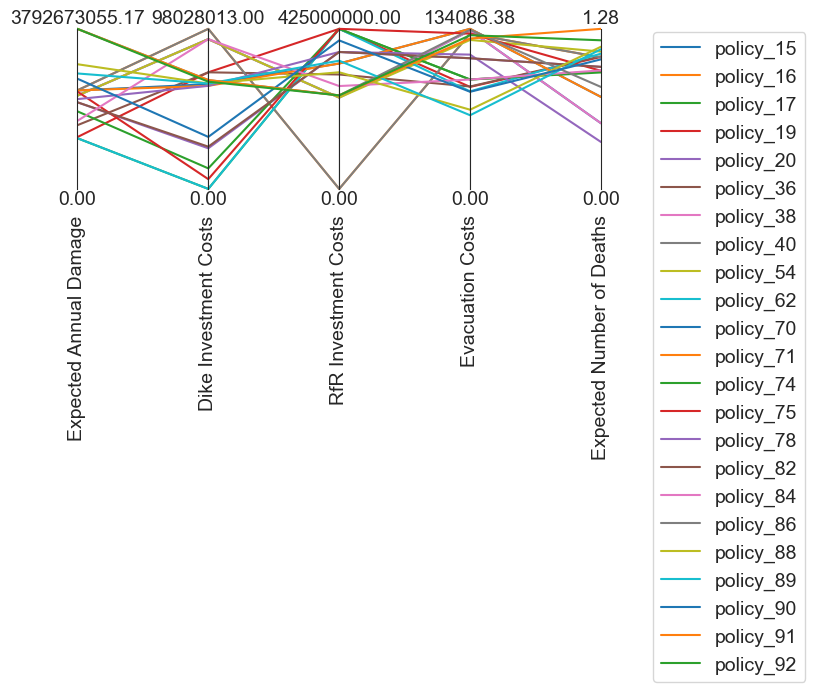

In [53]:
selected_outcomes = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

data = max_regret[selected_outcomes].copy()

# Get enough colors for all policies
colors = sns.color_palette(n_colors=len(data))

limits = parcoords.get_limits(data)
limits.loc[0, selected_outcomes] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

paraxes.legend()
plt.show()

In [57]:
policy_regret = defaultdict(dict)
for key, value in all_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

NameError: name 'all_regret' is not defined

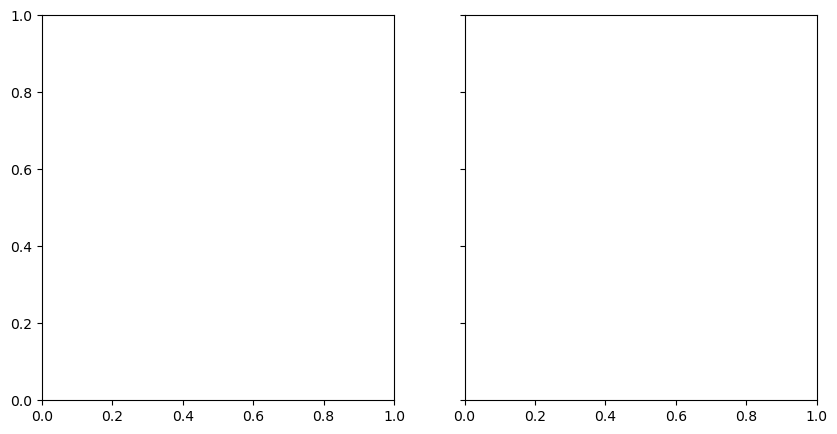

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5), 
                         sharey=True, sharex=True)

for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

In [65]:
x = experiments.iloc[:, :19] # Aanpassen
y = outcomes['Expected Number of Deaths']
a = y.quantile(0.85)
Y = (y > a).astype(int).values

prim_alg = prim.Prim(x, Y, threshold=0.5)
box1 = prim_alg.find_box()

NameError: name 'experiments' is not defined

In [67]:
box1.show_tradeoff()
plt.show()

NameError: name 'box1' is not defined

In [69]:
box1.inspect_tradeoff()

NameError: name 'box1' is not defined

In [71]:
#box.inspect(42)